<center>
<h1>Fake news detection using graph neural network</h1>
<h2>SAGE GNN</h2>
<i><h6>Victor GOUBET | Nicholas Tagliapietra | Asma Bakhtiariazad</h6></i>
</center>


----

# Library

In [1]:
import torch
import pickle as pk
import torch.nn.functional as F

from torch.nn import Linear, LogSoftmax
from tool_box.upfd_dataset import ext_UPFD
from tool_box.GNN_train import plot_hist, train_all, val_step, train_all_optuna
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool

# Import datasets

In [2]:
datasets = pk.load(open('./data/datasets.pkl', 'rb'))

# Define the model

In [3]:
class SAGE(torch.nn.Module):
    
    def __init__(self, num_n_feature, num_g_feature, emb_size, num_layers=2):
        super(SAGE, self).__init__()
        torch.manual_seed(42)
        self.emb_size = emb_size
        
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            size_in = num_n_feature if i == 0 else emb_size
            self.convs.append(SAGEConv(size_in, emb_size))

        # check if we have graph features to concatenate or not
        i = 2
        if num_g_feature:
             self.lin_g = Linear(num_g_feature, emb_size)
             i = 3

        self.out_layer = Linear(i * emb_size, 2)
        self.act = LogSoftmax(dim=-1)


    
    def forward(self, x, edges_idx, batch_idx, g_features):
        for i, conv in enumerate(self.convs):
            x = conv(x, edges_idx)
            if i != len(self.convs) - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
            else:
                
                flatten = torch.cat([global_mean_pool(x, batch_idx),
                                     global_max_pool(x, batch_idx)], axis=1)
                
                if g_features.size()[-1]>1:
                    g_ft = self.lin_g(g_features)
                    flatten = torch.cat([flatten, g_ft], axis=1)

                out = self.act(self.out_layer(flatten))
                
        return out

# Training

In [4]:
epochs = 60     
models = train_all_optuna(SAGE,datasets,epochs = epochs)

[I 2022-01-02 20:03:04,880] A new study created in memory with name: no-name-71c797c0-ebdb-44a1-8905-644933ae9edd


--> Train on: origin


[I 2022-01-02 20:05:06,827] Trial 0 finished with value: 0.7798138786764706 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.7798138786764706.
[I 2022-01-02 20:06:11,101] Trial 1 finished with value: 0.5045189950980392 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.01, 'batch_size': 256, 'embedding_space_dim': 120}. Best is trial 0 with value: 0.7798138786764706.
[I 2022-01-02 20:07:00,722] Trial 2 finished with value: 0.7771139705882352 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 256, 'embedding_space_dim': 80}. Best is trial 0 with value: 0.7798138786764706.
[I 2022-01-02 20:08:15,949] Trial 3 finished with value: 0.9519301470588235 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'embedding_space_dim': 100}. Best is trial 3 with value: 0.9519301470588235.
[I 2022-01-02 20:10:06,913] Trial 4 finished with value: 0.

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.24045587910546196  loss_val=0.5633790612220764 | acc_train=0.893484477124183  acc_val=0.7583639705882353
Epochs: 20 | loss_train=0.17193284382422766  loss_val=0.2667556285858154 | acc_train=0.9420445261437909  acc_val=0.8991727941176471
Epochs: 30 | loss_train=0.14670791973670325  loss_val=0.15150047242641448 | acc_train=0.9412785947712418  acc_val=0.9425551470588236
Epochs: 40 | loss_train=0.13550446099705166  loss_val=0.1782907396554947 | acc_train=0.9535334967320261  acc_val=0.9342830882352942
Epochs: 50 | loss_train=0.13623305492930943  loss_val=0.19588316082954407 | acc_train=0.9490910947712418  acc_val=0.9319852941176471
Epochs: 60 | loss_train=0.12101349896854824  loss_val=0.1188177838921547 | acc_train=0.9628778594771242  acc_val=0.959375


[I 2022-01-02 20:20:45,643] A new study created in memory with name: no-name-9682d978-bcbb-418a-8510-bc46c9e17783


--> Train on: dataset1


[I 2022-01-02 20:22:34,850] Trial 0 finished with value: 0.6124195772058824 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.6124195772058824.
[I 2022-01-02 20:23:08,131] Trial 1 finished with value: 0.7874540441176471 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.005, 'batch_size': 256, 'embedding_space_dim': 60}. Best is trial 1 with value: 0.7874540441176471.
[I 2022-01-02 20:23:42,586] Trial 2 finished with value: 0.7951286764705883 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 128, 'embedding_space_dim': 60}. Best is trial 2 with value: 0.7951286764705883.
[I 2022-01-02 20:24:37,887] Trial 3 finished with value: 0.7841605392156863 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.01, 'batch_size': 256, 'embedding_space_dim': 100}. Best is trial 2 with value: 0.7951286764705883.
[I 2022-01-02 20:25:53,444] Trial 4 finished with value: 0.82

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.721787240770128  loss_val=1.5298557519912719 | acc_train=0.7678206699346405  acc_val=0.7302389705882353
Epochs: 20 | loss_train=0.46466561489635044  loss_val=0.9093629837036132 | acc_train=0.8205678104575163  acc_val=0.5931066176470589
Epochs: 30 | loss_train=0.4192582501305474  loss_val=0.4327524840831757 | acc_train=0.8379289215686274  acc_val=0.8216911764705882
Epochs: 40 | loss_train=0.6282458172904121  loss_val=0.5235055685043335 | acc_train=0.7982026143790849  acc_val=0.7733455882352941
Epochs: 50 | loss_train=0.3565044667985704  loss_val=0.6837562799453736 | acc_train=0.8698427287581699  acc_val=0.8440257352941176
Epochs: 60 | loss_train=0.34804564548863304  loss_val=0.3661461710929871 | acc_train=0.862796160130719  acc_val=0.8745404411764707


[I 2022-01-02 20:31:25,994] A new study created in memory with name: no-name-5692e7af-50c3-4c90-9cd1-4feee7f52b90


--> Train on: dataset2


[I 2022-01-02 20:33:19,019] Trial 0 finished with value: 0.7660845588235294 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.7660845588235294.
[I 2022-01-02 20:34:47,424] Trial 1 finished with value: 0.6740579044117647 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.01, 'batch_size': 512, 'embedding_space_dim': 140}. Best is trial 0 with value: 0.7660845588235294.
[I 2022-01-02 20:35:30,652] Trial 2 finished with value: 0.8736213235294118 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 256, 'embedding_space_dim': 80}. Best is trial 2 with value: 0.8736213235294118.
[I 2022-01-02 20:36:56,896] Trial 3 finished with value: 0.6985294117647058 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 140}. Best is trial 2 with value: 0.8736213235294118.
[I 2022-01-02 20:37:31,619] Trial 4 finished with value: 0

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.5724221885204315  loss_val=0.52185986439387 | acc_train=0.7443474264705883  acc_val=0.8077512254901961
Epochs: 20 | loss_train=0.3847810924053192  loss_val=0.4421970744927724 | acc_train=0.8389705882352942  acc_val=0.8168658088235294
Epochs: 30 | loss_train=0.35500459671020507  loss_val=0.4531112511952718 | acc_train=0.8682904411764707  acc_val=0.8200827205882352
Epochs: 40 | loss_train=0.4323475301265717  loss_val=0.5721356670061747 | acc_train=0.8176470588235294  acc_val=0.8023897058823529
Epochs: 50 | loss_train=0.3738188505172729  loss_val=0.40749857823054 | acc_train=0.8461397058823529  acc_val=0.8095894607843137
Epochs: 60 | loss_train=0.32071651220321656  loss_val=0.37075744072596234 | acc_train=0.8676930147058824  acc_val=0.8736213235294118


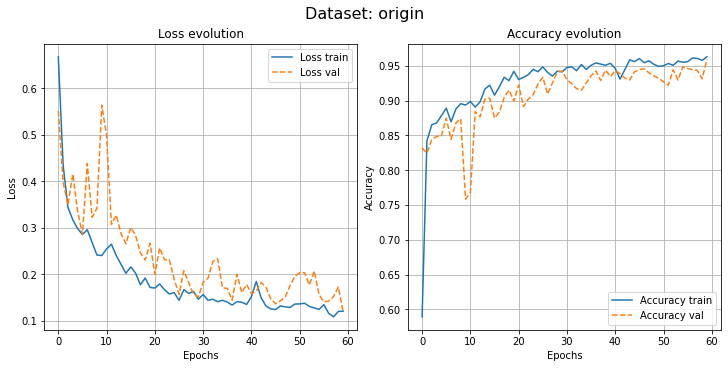

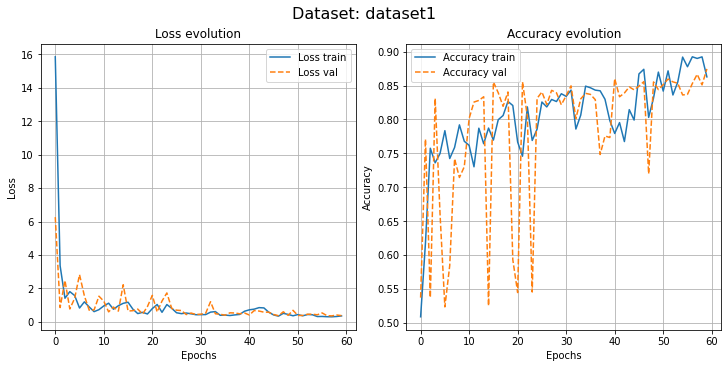

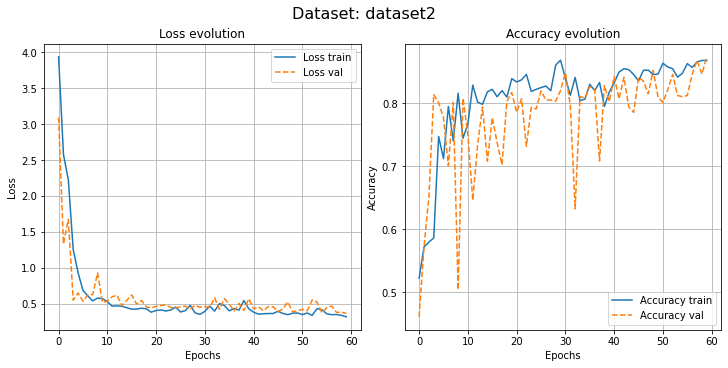

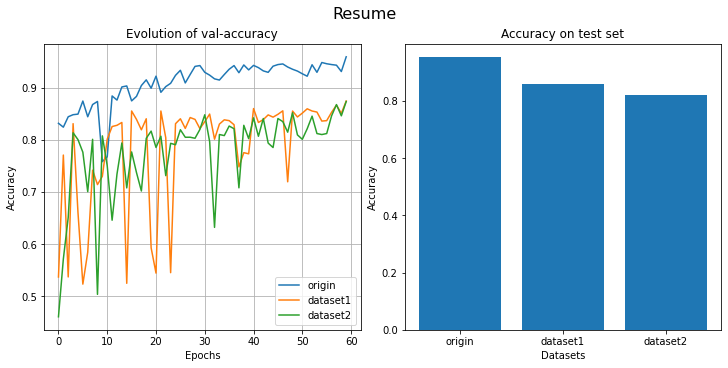

In [5]:
plot_hist(models)